# Using manipulated data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tick
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
import os
from scipy.optimize import minimize_scalar

In [3]:
# Set global font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'Georgia']
plt.rcParams['font.size'] = 14

In [4]:
def simulate_markov_chain(P, num_steps, start_state=0, sc = 0.01):
    """
    Simulate a Markov chain given a transition matrix P.
    
    Parameters:
    - P: Transition matrix (2D numpy array)
    - num_steps: Number of steps to simulate
    - start_state: Initial state (default is 0)
    
    Returns:
    - List of states over time
    """
    np.random.seed(0)
    # Ensure the matrix is a numpy array
    P = np.array(P)
    
    # Initialize the current state and the list to store the sequence of states
    current_state = start_state
    states = [current_state]
    Values = np.array([-sc, sc])
    # Simulate the Markov chain
    for _ in range(num_steps):
        next_state = np.random.choice(len(P), p=P[current_state])
        states.append(next_state)
        current_state = next_state
    val = [Values[s] for s in states]    
    return val

## Read data

In [5]:
stock = 'INTC'
lob_level = 1
p = 'lobdataread'
msgfile = os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_message_{lob_level}.csv')
obfile =  os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_orderbook_{lob_level}.csv')
df1=pd.read_csv(msgfile, sep=',', header=None, 
        names=['time', 'type', 'ord_id', 'size', 'price', 'dir'],
        dtype={'time':np.float64, 'type':np.int32, 'ord_id':np.int32, 
               'size':np.int64, 'price':np.int64, 'dir':np.int32})

df2=pd.read_csv(obfile, sep=',', header=None, 
        names=['ask_prc_L1', 'ask_sz_L1', 'bid_prc_L1', 'bid_sz_L1'],
        dtype={'ask_prc_L1':np.float64, 'ask_sz_L1':np.int64, 'bid_prc_L1':np.float64, 'bid_sz_L1':np.int64})

df3 = pd.concat([df1, df2], axis=1)
df3 = df3.drop_duplicates(subset='time', keep='first')
df3['mid_price'] = (df3['ask_prc_L1'] + df3['bid_prc_L1'])/2
df3['datetime'] = pd.to_timedelta(df3['time'], unit='s') + pd.Timestamp("2012-06-21")
df3 = df3[(df3['datetime'].dt.time >= pd.Timestamp('2012-06-21 09:46:00').time()) & 
                 (df3['datetime'].dt.time <= pd.Timestamp('2012-06-21 15:44:00').time())]

In [6]:
df3.head()

,time,type,ord_id,size,price,dir,ask_prc_L1,ask_sz_L1,bid_prc_L1,bid_sz_L1,mid_price,datetime
41062,35160.279815,1,35222791,200,273300,-1,273300.0,9389,273200.0,6800,273250.0,2012-06-21 09:46:00.279815253
41063,35160.644008,3,35222791,200,273300,-1,273300.0,9189,273200.0,6800,273250.0,2012-06-21 09:46:00.644008345
41064,35160.644074,3,35216767,300,273300,-1,273300.0,8889,273200.0,6800,273250.0,2012-06-21 09:46:00.644074264
41065,35160.711482,1,35229056,600,273300,-1,273300.0,9489,273200.0,6800,273250.0,2012-06-21 09:46:00.711481589
41066,35160.711560,1,35229060,300,273300,-1,273300.0,9789,273200.0,6800,273250.0,2012-06-21 09:46:00.711559714


In [7]:
df = df3[['time', 'datetime', 'mid_price']].copy()
df['mid_price'] = df['mid_price']/10000 
df.loc[:, 'mid_price'] = df['mid_price'] - df['mid_price'].iloc[0]
df.loc[:, 'time'] = df['time'] - df['time'].iloc[0]
df.reset_index(drop=True, inplace=True)
df['mid_diff'] = df['mid_price'].diff()
# Replace NaN with 0 at the beginning
df['mid_diff'].fillna(0, inplace=True)
threshold = 1e-6
df = df[df['mid_diff'].abs() >= threshold]
df.reset_index(drop=True, inplace=True)

In [8]:
df.head(5)

,time,datetime,mid_price,mid_diff
0,21.008641,2012-06-21 09:46:21.288456486,0.005,0.005
1,21.010310,2012-06-21 09:46:21.290125409,0.010,0.005
2,23.676004,2012-06-21 09:46:23.955819413,0.015,0.005
3,23.676044,2012-06-21 09:46:23.955859632,0.020,0.005
4,45.936385,2012-06-21 09:46:46.216200172,0.030,0.010


In [9]:
df_positive = df[df['mid_diff'] >= 0]
df_negative = df[df['mid_diff'] < 0]
quantiles_positive = df_positive['mid_diff'].quantile(0.5)
quantiles_negative = df_negative['mid_diff'].quantile(0.5)
a_ = [df_negative["mid_diff"].mean(), df_positive["mid_diff"].mean()]
a_

[-0.005082949308755826, 0.005056935817805458]

In [10]:
df['mid_diff'] = np.where(df['mid_diff'] >= 0, a_[1], a_[0])

In [11]:
df.isnull().any()

time         False
datetime     False
mid_price    False
mid_diff     False
dtype: bool

In [12]:
df = df[['time', 'datetime', 'mid_diff', 'mid_price']]

In [13]:
%matplotlib inline
#df.mid_price.plot(figsize = (4,2))

In [14]:
from scipy.optimize import minimize_scalar

In [15]:
timestamps_list = [df['time'].values]
# Define a function to compute the negative hawkes score for a given decay
def negative_hawkes_score(decay):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000, tol=1e-10)
    hawkes_learner.fit(timestamps_list)
    return -hawkes_learner.score()

# Use minimize_scalar to find the decay that minimizes the negative hawkes score
result = minimize_scalar(negative_hawkes_score, bounds=(500, 5000), method='bounded')

# Extract the optimal decay and the maximum hawkes score from the result
optimal_decay = result.x
max_score = -result.fun

print("Optimal Decay Value:", optimal_decay)
print("Maximum Hawkes Score:", max_score)
best_hawkes = HawkesExpKern(optimal_decay, verbose=False, max_iter=10000, tol=1e-10)
best_hawkes.fit(timestamps_list)
best_decay = optimal_decay
best_score = best_hawkes.score()

Optimal Decay Value: 2625.945669294753
Maximum Hawkes Score: 237.58300754378703


In [16]:
print(f'n = {best_hawkes.n_nodes}',
      f'mu = {best_hawkes.baseline}', 
      f'alpha = {best_hawkes.adjacency}', '\n'
      f'beta = {best_decay}, alpha_p = {best_hawkes.adjacency * best_decay}, score = {best_score}')

n = 1 mu = [0.06227941] alpha = [[0.34445911]] 
beta = 2625.945669294753, alpha_p = [[904.53089993]], score = 237.58300754378703


In [17]:
df_ = df
df_ = df.set_index('datetime')
print(df_['mid_diff'].resample("1S").count().mean())
print(best_hawkes.baseline[0]/(1 - best_hawkes.adjacency[0][0]))

0.09559097688292319
0.09500461379853127


## Markov Process

In [18]:
df['state'] = np.nan
df.loc[df['mid_diff'] < 0, 'state'] = 0
df.loc[df['mid_diff'] >= 0, 'state'] = 1 
df['state'] = df['state'].astype(int)

## Transition probability

In [19]:
n_state_tot = 2
# Initialize transition matrix
transition_matrix = np.zeros((n_state_tot, n_state_tot))

# Compute transitions
for i in range(len(df['state']) - 1):
    current_state = df['state'].iloc[i]
    next_state = df['state'].iloc[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_probs = transition_matrix / transition_matrix.sum(axis=1)[:, None]
print(transition_probs)

[[0.61531365 0.38468635]
 [0.43271222 0.56728778]]


In [20]:
# Assuming transition_probs is your transition matrix
P = transition_probs

# Create a matrix where each row is P - I
matrix = P.T - np.eye(P.shape[0])

# Replace the last row with ones to account for the probability constraint
matrix[-1, :] = 1

# Create the target vector, with a 1 at the end for the probability constraint
target = np.zeros(P.shape[0])
target[-1] = 1

# Solve the linear system
stationary_probs = np.linalg.solve(matrix, target)

print(stationary_probs)
print("================")
print(stationary_probs @ P)
print("================")
print(np.sum(stationary_probs))

[0.52937727 0.47062273]
[0.52937727 0.47062273]
1.0


## General compound

\begin{equation}
v(i) = b(i)^2 + \sum_{j \in S} (g(j) - g(i))^2 P(i, j) - 2b(i) \sum_{j \in S} (g(j) - g(i)) P(i, j)
\end{equation}

In [21]:
def compute_v(b, g, P):
    """
    Compute v based on the given formula.
    
    Parameters:
    - i: the current state
    - b: a function or dictionary that gives b(i) for each i
    - g: a function or dictionary that gives g(i) for each i
    - P: a 2D array or dictionary of dictionaries that gives P(i, j) for each pair i, j    
    Returns:
    - v
    """
    v = np.zeros(b.shape)
    S = np.array([i for i in range(len(b))])
    for i in range(len(b)):
        term1 = b[i]**2
        term2 = np.sum([(g[j] - g[i])**2 * P[i][j] for j in S])
        term3 = -2 * b[i] * np.sum([(g[j] - g[i]) * P[i][j] for j in S])
        v[i] = term1 + term2 + term3
    
    return v

In [22]:
# np.dot(stationary_probs, transition_probs), stationary_probs

In [23]:
lam = best_hawkes.baseline
alpha = best_hawkes.adjacency
beta = best_decay
mu_hat = alpha# (alpha*beta)/beta
a = np.array(a_)#a_negative + a_positive)
a_star = np.dot(stationary_probs, a)
b = a - a_star
# # compute g 
P = transition_probs
Pi = np.tile(stationary_probs, (len(stationary_probs), 1))
# Identity matrix
I = np.eye(n_state_tot)
# Compute the inverse of P + Pi - I
g = np.linalg.inv(P + Pi - I)@ b
v =compute_v(b, g, P) 
sigma_2 = np.dot(stationary_probs, v)
sigma = np.sqrt(sigma_2)
sigma_star = sigma * np.sqrt(lam / (1 - mu_hat))

In [24]:
transition_probs, sigma, a_star, mu_hat, lam

(array([[0.61531365, 0.38468635],
        [0.43271222, 0.56728778]]),
 0.006087716173444377,
 -0.00031088883861248625,
 array([[0.34445911]]),
 array([0.06227941]))

In [25]:
df['mid_price2'] = np.cumsum(df['mid_diff'])
df['datetime'] = pd.to_datetime(df['datetime'])

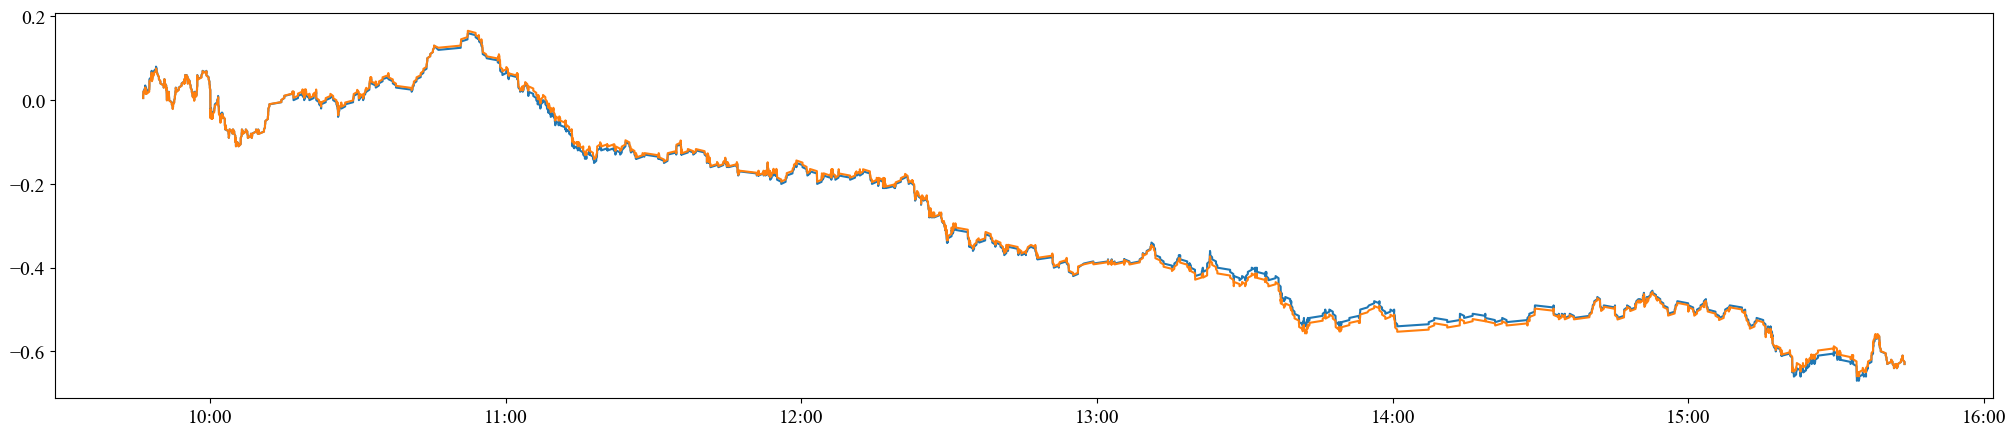

In [26]:
%matplotlib inline
import matplotlib
fig, ax = plt.subplots(1,1, figsize  = (25,5))
ax.plot(df.datetime, df.mid_price)
ax.plot(df.datetime, df.mid_price2)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
#ax.set_xlim([0, 21400])
#ax.set_ylim([-5, 2])

In [27]:
df.tail()

,time,datetime,mid_diff,mid_price,state,mid_price2
2046,21452.919430,2012-06-21 15:43:33.199245064,0.005057,-0.610,1,-0.609668
2047,21454.223017,2012-06-21 15:43:34.502831884,-0.005083,-0.615,0,-0.614751
2048,21454.224686,2012-06-21 15:43:34.504500853,-0.005083,-0.620,0,-0.619834
2049,21476.544711,2012-06-21 15:43:56.824525874,-0.005083,-0.625,0,-0.624917
2050,21476.545401,2012-06-21 15:43:56.825216174,-0.005083,-0.630,0,-0.630000


In [28]:
df_ = df
df_ = df.set_index('datetime')
windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
std_values = {}
std_values_theory = {}
for window in windows:
    window = str(window) + 'S'
    mid_price =  df_['mid_price'].resample(window).apply(lambda x: x[-1] - x[0])
    jump = df_['mid_price'].resample(window).size() * a_star
    p_result = mid_price - jump
                  
    std_value = p_result.dropna().std()
    std_values[window] = std_value
    n = float(window.replace('S',''))
    std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()

# Plotting the results
#std_values, std_values_theory
#std_values, std_values_theory
x = [int(key[:-1]) for key in std_values.keys()]
y = list(std_values.values())
# Fit 2nd order polynomial
z2 = np.polyfit(x, y, 2)
p2 = np.poly1d(z2)

# Fit 3rd order polynomial
z3 = np.polyfit(x, y, 3)
p3 = np.poly1d(z3)

In [29]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
def mycurvefit(std_values, std_values_theory):
    x = [int(key[:-1]) for key in std_values.keys()]
    y = list(std_values.values())

    def func(x, a, b):
        return a * np.sqrt(x) + b
    params, covariance = curve_fit(func, x, y)
    a, b = params
    y_pred = func(x, a, b)
    y_true = list(std_values_theory.values())
    #y_signal = y
    return  y_pred, y_true, a, b
y_pred, y_true, a, b = mycurvefit(std_values, std_values_theory)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(rmse)
print("& ".join(map(str, [a, b, rmse])))

0.000518935835112104
0.0019310496429950676& -0.0010390295479814834& 0.000518935835112104


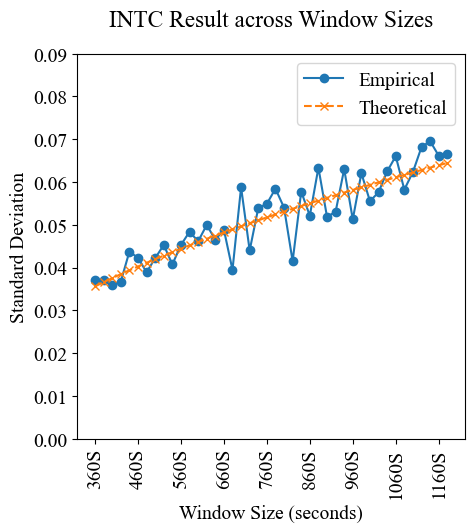

In [30]:
# Plotting the results
plt.figure(figsize=(5, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
#plt.plot(list(std_values.keys()), p2(x), color='red', label='2nd order fit')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('INTC Result across Window Sizes', y=1.05)
plt.legend()
#plt.xticks(rotation=90)
n = 5
keys = list(std_values.keys())
plt.xticks(keys[::n], keys[::n], rotation=90)

plt.ylim([0, 0.09])
#plt.grid(True)
plt.savefig("./pics/intc_std.png", dpi=300, bbox_inches='tight')
plt.show()